In [1]:
from google.colab import drive

In [27]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow import keras

In [3]:
from google.colab import files
uploaded = files.upload()

Saving PlantVillage.zip to PlantVillage.zip


In [4]:
import zipfile
import os

zip_path = "PlantVillage.zip"
extract_path = "PlantVillage"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [5]:
print(os.listdir(extract_path))


['PlantVillage']


In [6]:
actual_data_path = os.path.join(extract_path, "PlantVillage")


In [36]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 10



In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    actual_data_path,      # Path to PlantVillage folder
    seed=123,
    shuffle=True,
    image_size=(224, 224),
    batch_size=32
)


Found 2015 files belonging to 2 classes.


In [9]:
# Class names
class_names = dataset.class_names
print("Class Names:", class_names)

Class Names: ['Potato___Late_blight', 'Potato___healthy']


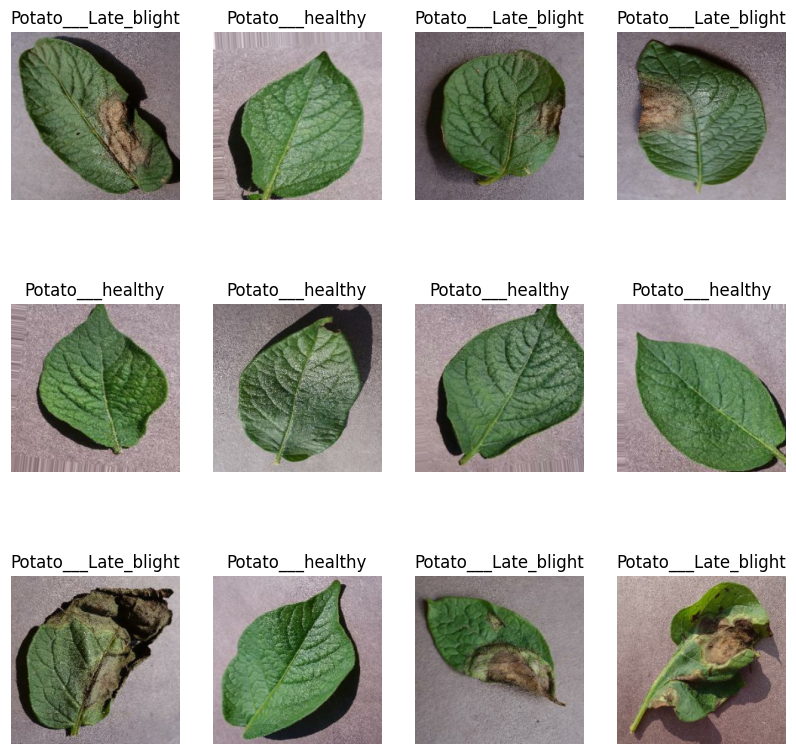

In [10]:
# Visualize some sample images
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [16]:
# Split dataset
train_size = 0.8
val_size = 0.1
test_size = 0.1

In [17]:
import tensorflow as tf
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)

# 1. Load dataset from directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    actual_data_path,
    seed=123,
    shuffle=True,
    image_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE
)

# 2. Split function
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + val_split + test_split) == 1

    ds = ds.shuffle(1000, seed=12)
    ds_size = tf.data.experimental.cardinality(ds).numpy()

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return (
        train_ds.prefetch(tf.data.AUTOTUNE),
        val_ds.prefetch(tf.data.AUTOTUNE),
        test_ds.prefetch(tf.data.AUTOTUNE)
    )

# 3. Split dataset
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


Found 2015 files belonging to 2 classes.


In [18]:
print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())


Train batches: 50
Validation batches: 6
Test batches: 7


In [19]:
# Optimize performance with caching and prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


PRE-PROCESSING

In [20]:
# resizing and normalizing pixel values
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1.0/255) # Normalizing the pixel values helps training converge faster and more accurately.
])

train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))


In [21]:
# data augmentation

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

train_ds = train_ds.map(augment)


In [22]:
# Shape of our training batch
for img, label in train_ds.take(1):
    print("New shape:", img.shape)


New shape: (32, 224, 224, 3)


MOBILENET V2

In [23]:
# Load MobileNet V2 as the base model
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
# Freezing the Base
base_model.trainable = False

In [25]:
# Adding our pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [28]:
# Adding the prediction Layer
prediction_layer = keras.layers.Dense(4, activation="softmax")

In [29]:
#combining the layers together in a model.
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])


In [30]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [31]:
learning_rate = 0.001

model.compile( optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [32]:
# Now we can train it on our images
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 305ms/step - accuracy: 0.8302 - loss: 0.4375 - val_accuracy: 0.9896 - val_loss: 0.1305
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - accuracy: 0.9605 - loss: 0.1266 - val_accuracy: 0.9896 - val_loss: 0.0767
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9827 - loss: 0.0787 - val_accuracy: 0.9948 - val_loss: 0.0612
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.9810 - loss: 0.0731 - val_accuracy: 0.9948 - val_loss: 0.0537
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.9834 - loss: 0.0576 - val_accuracy: 0.9896 - val_loss: 0.0439
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.9854 - loss: 0.0477 - val_accuracy: 0.9948 - val_loss: 0.0394
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9886 - loss: 0.0418 - val_accuracy: 0.9948 - val_loss: 0.0383
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.9832 - loss: 0.0489 - val_accuracy: 1.000

In [33]:
# Evaluate the model on the test dataset
scores = model.evaluate(test_ds)
print("Test accuracy:", scores[1])


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9923 - loss: 0.0396
Test accuracy: 0.9866071343421936


In [34]:
#plotting training results (accuracy and loss)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

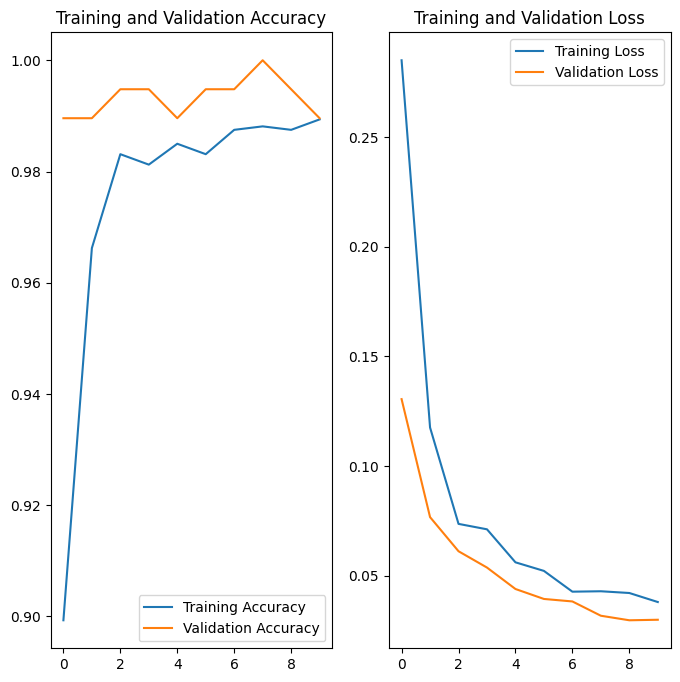

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

EVALUATION

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
[[106   1]
 [  2 115]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       107
           1       0.99      0.98      0.99       117

    accuracy                           0.99       224
   macro avg       0.99      0.99      0.99       224
weighted avg       0.99      0.99      0.99       224



In [40]:
# Save the model
model.save('mnet2.h5')

USECASE

Saving download.jpg to download (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


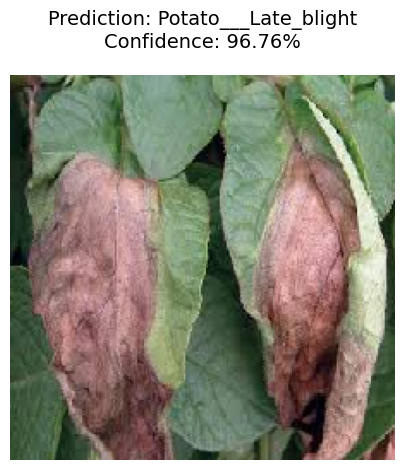

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from google.colab import files

# Constants
IMAGE_SIZE = 224
classes =  ['Potato___Late_blight', 'Potato___healthy']

# Load your model (make sure it's uploaded to Colab or in your Drive)
model = keras.models.load_model('mnet2.h5')

# Upload image file from your local device
uploaded = files.upload()  # You can select an image file from your computer

# Get uploaded image path
img_path = list(uploaded.keys())[0]  # This takes the first uploaded file name

def predict_and_display(model, img_path, class_names=classes):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_index]
    confidence_score = predictions[0][predicted_class_index]

    # Display image and prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence_score:.2%}", fontsize=14, pad=20)
    plt.show()

# Run prediction
predict_and_display(model, img_path)


In [56]:
!ls


'00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864 (1).JPG'   cat.jpg
'00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG'      'download (1).jpg'
'1a1184f8-c414-4ead-a4c4-41ae78e29a82___RS_HL 1971 (1).JPG'  'download (2).jpg'
'1a1184f8-c414-4ead-a4c4-41ae78e29a82___RS_HL 1971.JPG'       download.jpg
'2f76c068-ebba-499d-8819-2d12bde41695___RS_LB 3232.JPG'       mnet2.h5
'61b8a692-91d8-40f5-a4a4-4d910875a638___RS_HL 1966.JPG'       PlantVillage
'9a6eb7c4-6b43-477a-89e0-69f62ef67991___RS_HL 1846.JPG'       PlantVillage.zip
'cat (1).jpg'						      sample_data


In [62]:
from google.colab import files
files.download('mnet2.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CNNs

In [63]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

XCEPTION

In [64]:
from tensorflow.keras.applications.xception import Xception


def make_model(learning_rate):


    IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=IMG_SHAPE
    )

    base_model.trainable = False


    vectors = tf.keras.layers.GlobalAveragePooling2D()


    outputs = keras.layers.Dense(4, activation="softmax")


    model = tf.keras.Sequential([
                                base_model,
                                vectors,
                                outputs
                                ])


    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model



In [65]:
learning_rate = 0.001

model = make_model(learning_rate=learning_rate)
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 333ms/step - accuracy: 0.6617 - loss: 0.7015 - val_accuracy: 0.9531 - val_loss: 0.2053
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9479 - loss: 0.1929 - val_accuracy: 0.9740 - val_loss: 0.1355
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9471 - loss: 0.1526 - val_accuracy: 0.9792 - val_loss: 0.1108
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9581 - loss: 0.1324 - val_accuracy: 0.9792 - val_loss: 0.0956
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.9728 - loss: 0.0965 - val_accuracy: 0.9792 - val_loss: 0.0815
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.9673 - loss: 0.0943 - val_accuracy: 0.9792 - val_loss: 0.0758
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9692 - loss: 0.0926 - val_accuracy: 0.9792 - val_loss: 0.0707
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step

In [66]:
# Evaluate the model on the test dataset
scores = model.evaluate(test_ds)
print("Test accuracy:", scores[1])


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9856 - loss: 0.0817
Test accuracy: 0.9821428656578064


In [67]:
#plotting training results (accuracy and loss)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

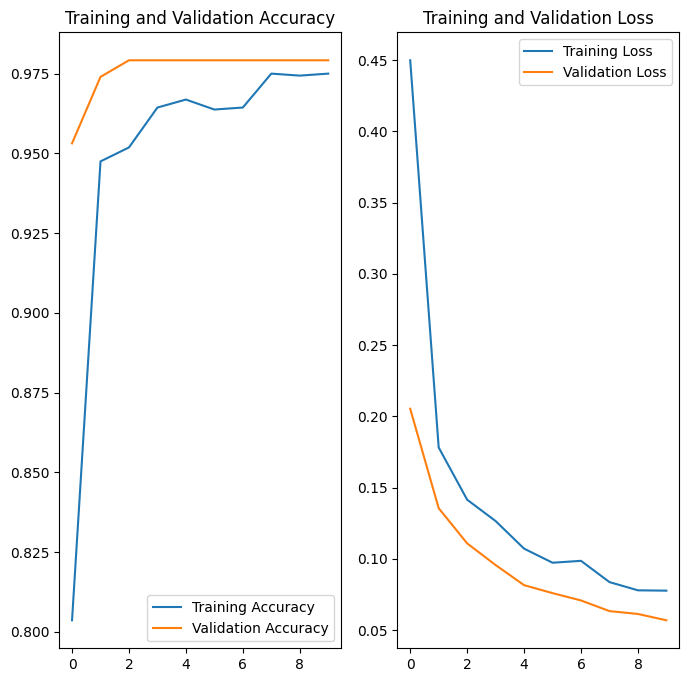

In [68]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [69]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
[[106   1]
 [  3 114]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       107
           1       0.99      0.97      0.98       117

    accuracy                           0.98       224
   macro avg       0.98      0.98      0.98       224
weighted avg       0.98      0.98      0.98       224



In [70]:
# Save the model
model.save('xception.h5')

Saving lb1.jpg to lb1 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


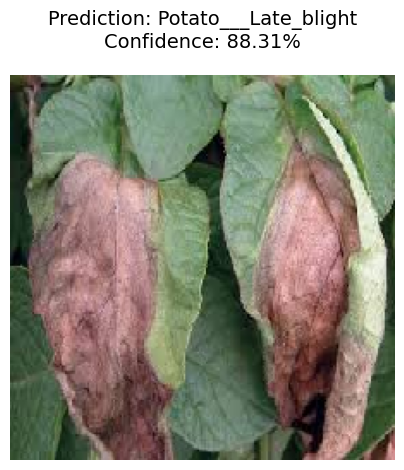

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from google.colab import files

# Constants
IMAGE_SIZE = 224
classes =  ['Potato___Late_blight', 'Potato___healthy']

# Load your model (make sure it's uploaded to Colab or in your Drive)
model = keras.models.load_model('xception.h5')

# Upload image file from your local device
uploaded = files.upload()  # You can select an image file from your computer

# Get uploaded image path
img_path = list(uploaded.keys())[0]  # This takes the first uploaded file name

def predict_and_display(model, img_path, class_names=classes):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_index]
    confidence_score = predictions[0][predicted_class_index]

    # Display image and prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence_score:.2%}", fontsize=14, pad=20)
    plt.show()

# Run prediction
predict_and_display(model, img_path)


In [79]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report

# Define class names
class_names = ['Potato___Late_blight', 'Potato___healthy']

# 1. Load both models
mobilenet_model = tf.keras.models.load_model('mnet2.h5')
xception_model = tf.keras.models.load_model('xception.h5')

# 2. Prepare test data (ensure test_ds is batched and not shuffled)
y_true = []
y_pred_mobilenet = []
y_pred_xception = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())  # Directly use the labels if they're already in the correct format

    # Predict with MobileNet
    preds_mobilenet = mobilenet_model.predict(images)
    y_pred_mobilenet.extend(np.argmax(preds_mobilenet, axis=1))

    # Predict with Xception
    preds_xception = xception_model.predict(images)
    y_pred_xception.extend(np.argmax(preds_xception, axis=1))

# 3. Generate and print classification reports
print("=== MobileNetV2 Classification Report ===")
print(classification_report(y_true, y_pred_mobilenet, target_names=class_names))

print("\n=== Xception Classification Report ===")
print(classification_report(y_true, y_pred_xception, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
=== MobileNetV2 Classification Report ===
                      precision    recall  f1-score   support

Potato___Late_blight       0.98      0.99      0.99       107
    Potato___healthy       0.99      0.98      0.99       117

            accuracy                           0.99       224
           macro avg       0.99      0.99      0.99       224
        weighted avg       0.99      0.99      0.99       224


=== Xception Classification Report ===
         